In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import math
import networkx as nx

### Import Environment

In [2]:
Atascosa = nx.read_shp(r'Atascosa\edges.shp')
nodes_data = nx.read_shp(r'Atascosa\nodes.shp')

for e in Atascosa.edges.data():
    if (e[1], e[0]) not in Atascosa:
        Atascosa.add_edge(e[1], e[0])
        
        for A in e[2]:
            Atascosa[e[1]][e[0]][A] = e[2][A]
        
for n in nodes_data.nodes.data():
    for A in n[1]:
        Atascosa.nodes[n[0]][A] = n[1][A]

In [3]:
clusters = []
for x in Atascosa.nodes.data():
    if x[1]['well']=='1':
        clusters.append(tuple([x[0], x[1]['Size']])) # the size variable can be removed if unwanted
        
clusters

[((-98.346983635, 28.90336087), 2),
 ((-98.68425455333333, 29.17836441), 3),
 ((-98.74054584333332, 28.83449039333333), 3),
 ((-98.63923124499999, 28.85497386), 2),
 ((-98.80039774, 29.184725325000002), 2),
 ((-98.70341999, 29.17525964), 1),
 ((-98.76985064, 28.9485843), 1),
 ((-98.72930564, 29.05115702), 1),
 ((-98.16279453499999, 28.750711709999997), 2),
 ((-98.735289493, 28.884813801), 20),
 ((-98.75172126999999, 28.87813230142857), 7),
 ((-98.52448421, 28.87908197), 1),
 ((-98.19564892, 28.7736562), 1),
 ((-98.73690283, 28.81946942), 1),
 ((-98.28129662, 28.89002402), 1),
 ((-98.76065773, 29.19713571), 1),
 ((-98.73506198285712, 28.90698824714286), 7),
 ((-98.72745071, 28.86660764), 1),
 ((-98.65527190210526, 29.18506977894737), 19),
 ((-98.72010547, 29.18036479), 1),
 ((-98.34134356999999, 28.920911033333336), 6),
 ((-98.791694495, 29.00298879), 2)]

### Reinforcement Learner

For our learner algorithm, I've decided to use a Deep Q Learning (DQL) network, in order to help generalize each state. The main idea came from this link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
<br>MLP Code: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [4]:
# Hyperparameter Control Panel

R_EARTH = 3958.8                # Radius of Earth in miles

OUTPUT_SIZE = 1                 # Length of NN output
NUM_FEATURES = 5                # Length of NN input (# of features)

EPSILON_START = 5               # Initial epsilon value for dynamic epsilon greedy
EPSILON_CONST = 0.25            # Constant epsilon value for static epsilon greedy
EPSILON_STATIC = False          # Boolean value that determines type of epsilon value

lr = 0.1                        # Learning rate of NN

BATCH_SIZE = 5                  # Batch size when training learner [MAX VALUE: ~6]
FULL_SIZE = len(clusters)       # Full size of cluster dataset

START_NODE = 0                  # Index of starting cluster
num_episodes = 400

In [5]:
import random
import torch
import torch.nn as nn

class DQN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(DQN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.LeakyReLU(0.2)
            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.iter = 0
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

It'll be helpful to define a function to find the distance between clusters, as well as the dot product between a path and its center:

In [6]:
def total_distance(i, j): # Takes in indices of clusters and returns the total distance
    distance = 0
    path = nx.shortest_path(Atascosa, clusters[i][0], clusters[j][0])

    for k in range(1, len(path)): # Identifies the edge, stores the distance and adds it to the total distance
        distance += Atascosa.edges[path[k-1], path[k]]['Distance']
    return distance

In [7]:
def norm(x, y): # finds norm of a line formed from coordinates
    return np.sqrt((y[0]-x[0])**2 + (y[1]-x[1])**2)

def norm_dot_product(x, y, z=None, CORE=None): # x, y are start / end coordinates of a path (respectively)
    # z is called whenever an angle is formed between two edges; CORE is called whenever comparing the angle to the current average cluster point
    if z==None:
        return ( (y[0]-x[0])*(CORE[0]-x[0]) + (y[1]-x[1])*(CORE[1]-x[1]) ) / ( norm(x, CORE)*norm(x, y) )
    return ( (y[0]-x[0])*(z[0]-y[0]) + (y[1]-x[1])*(z[1]-y[1]) ) / ( norm(x, y)*norm(y, z) )

Below is a batch-generator: generates a random batch of indices within the specified range:

In [8]:
def get_batch():
    temp = [i for i in range(FULL_SIZE)]
    temp.remove(START_NODE) # we don't include the start node
    x = []
    
    for _ in range(BATCH_SIZE):
        x.append(temp.pop(random.randint(0, len(temp)-1)))
    return x

The iterator function returns the optimal path for a given batch (WARNING: Any batch size greater than ~5 will take a LONG time)

In [9]:
memo = [] # Memoization to prune bad branches and speed up process
def iterator(state, reset=True): # reset variable refers to when iterator is called: clears memory
    if reset:
        memo.clear()
        
    if state[2]==[]: # End state
        return [state[3], state[1]]
    
    for s in memo: # Runs through memory
        if s[0]==state[0] and set(s[1])==set(state[1]): # if they have same current position and similar past experiences...
            if state[3] >= s[3]: # stop if greater travel distance
                return [1e99, []]
            memo.remove(s) # replace memory value if better
            break
            
    memo.append(state) # add state to memory
    
    return min( iterator( (state[2][i], state[1]+[state[2][i]], state[2][:i]+state[2][i+1:], state[3]+total_distance(state[0], state[2][i])), False) for i in range(len(state[2])) )

State's will be comprised of: (0: Position [index], 1: Past actions, 2: Available actions, 3: Distance already traveled)

In [10]:
def extract_features(state, action): #action: node we're considering traveling to (index)
    # Measure existing "node-core" (average point of remaining clusters)
    clusters_remaining_x = [clusters[i][0][0] for i in state[2]+[action]]
    clusters_remaining_y = [clusters[i][0][1] for i in state[2]+[action]]
    CORE = sum(clusters_remaining_x)/(len(state[2])+1), sum(clusters_remaining_y)/(len(state[2])+1)
    
    distance = total_distance(state[0], action) / R_EARTH
    
    angle_from_prev = 0
    if len(state[1])>1:
        angle_from_prev = norm_dot_product(clusters[state[1][-2]][0], clusters[state[0]][0], clusters[action][0])
        
    angle_to_core = norm_dot_product(clusters[state[0]][0], clusters[action][0], CORE=CORE)
    distance_to_core = norm(clusters[state[0]][0], CORE)
    
    percent_visited = len(state[1]) / (len(state[1])+len(state[2]))
    
    x = [ distance, angle_from_prev, angle_to_core, distance_to_core, percent_visited ]
    
    return torch.FloatTensor(x)

In [11]:
policy_net = DQN(NUM_FEATURES, 2*NUM_FEATURES)

def select_action(state, opt=False): # epsilon greedy - opt: no exploration
    policy_net.iter += 1
    
    if EPSILON_STATIC: # If using a constant epsilon value, run the following
        if random.random() > EPSILON_CONST or opt:
            output = torch.FloatTensor([policy_net.forward(extract_features(state, action)) for action in state[2]])
            return state[2].pop( torch.argmax(output) )
        else:
            return state[2].pop(random.randint(0, len(state[2])-1))
    
    # Other use the dynamic epsilon value
    if random.random() > EPSILON_START/math.sqrt(policy_net.iter) or opt:
        output = torch.FloatTensor([policy_net.forward(extract_features(state, action)) for action in state[2]])
        return state[2].pop( torch.argmax(output) )
    else:
        return state[2].pop(random.randint(0, len(state[2])-1))

In [12]:
def incorporate_feedback(state, action, reward, newState):
    x = extract_features(state, action)
    Q = policy_net.forward(x)
    
    criterion = nn.MSELoss()
    
    loss = criterion(Q, reward*torch.ones(OUTPUT_SIZE)) # Loss = (Q-I[x])^2
        
    optimizer = torch.optim.SGD(policy_net.parameters(), lr = lr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return

Below is the training method for the learner:

In [13]:
SCORES = []

for i in range(num_episodes):
    print("Episode #", i)
    SCORES.append(0)
    
    # First restart the 'game'
    actions = get_batch() # Actions are the indices of clusters <- remove once visited
    state = (START_NODE, [START_NODE], actions, 0)
    PI_opt = iterator(state)[1] # The optimal policy for the batch
    print('Optimal Path:', PI_opt)
    
    while state!=None:
        action = select_action(state)
        optimal_action = PI_opt[len(state[1])]
        
        D = total_distance(state[0], action)
        
        newState = (action, state[1]+[action], state[2], state[3]+D)
        
        if action!=PI_opt[len(state[1])]: #update the optimal policy if a different action was taken
            PI_opt = iterator(newState)[1]
        
        reward = 2*int(action==optimal_action)-1 # reward is 1 if learner replicates PI_opt, -1 otherwise
        
        if len(newState[2])==0: # If no new possible actions, set newState to None
            print('Learner Path:', newState[1])
            newState = None
        
        incorporate_feedback(state, action, reward, newState)
        SCORES[-1] += reward
        
        state = newState

Episode # 0
Optimal Path: [0, 14, 8, 13, 6, 1]
Learner Path: [0, 1, 13, 14, 8, 6]
Episode # 1
Optimal Path: [0, 14, 8, 17, 6, 18]
Learner Path: [0, 14, 18, 8, 6, 17]
Episode # 2
Optimal Path: [0, 14, 12, 11, 7, 18]
Learner Path: [0, 14, 12, 7, 11, 18]
Episode # 3
Optimal Path: [0, 14, 12, 17, 10, 5]
Learner Path: [0, 17, 10, 5, 14, 12]
Episode # 4
Optimal Path: [0, 11, 3, 2, 10, 21]
Learner Path: [0, 2, 11, 3, 21, 10]
Episode # 5
Optimal Path: [0, 20, 16, 5, 15, 4]
Learner Path: [0, 20, 5, 15, 16, 4]
Episode # 6
Optimal Path: [0, 12, 18, 5, 19, 4]
Learner Path: [0, 4, 19, 18, 5, 12]
Episode # 7
Optimal Path: [0, 21, 18, 5, 15, 4]
Learner Path: [0, 15, 4, 18, 5, 21]
Episode # 8
Optimal Path: [0, 8, 14, 20, 19, 4]
Learner Path: [0, 14, 8, 19, 4, 20]
Episode # 9
Optimal Path: [0, 14, 17, 18, 19, 4]
Learner Path: [0, 14, 4, 19, 18, 17]
Episode # 10
Optimal Path: [0, 11, 2, 21, 15, 4]
Learner Path: [0, 21, 2, 11, 15, 4]
Episode # 11
Optimal Path: [0, 20, 11, 2, 6, 16]
Learner Path: [0, 2, 1

Optimal Path: [0, 17, 16, 6, 7, 5]
Learner Path: [0, 5, 6, 17, 7, 16]
Episode # 98
Optimal Path: [0, 12, 8, 7, 18, 5]
Learner Path: [0, 8, 12, 7, 18, 5]
Episode # 99
Optimal Path: [0, 20, 14, 12, 6, 18]
Learner Path: [0, 14, 12, 20, 18, 6]
Episode # 100
Optimal Path: [0, 14, 11, 2, 13, 4]
Learner Path: [0, 2, 13, 14, 11, 4]
Episode # 101
Optimal Path: [0, 8, 16, 6, 5, 4]
Learner Path: [0, 8, 16, 6, 4, 5]
Episode # 102
Optimal Path: [0, 11, 3, 2, 9, 4]
Learner Path: [0, 4, 2, 9, 11, 3]
Episode # 103
Optimal Path: [0, 12, 3, 13, 6, 16]
Learner Path: [0, 12, 16, 6, 13, 3]
Episode # 104
Optimal Path: [0, 3, 16, 21, 5, 4]
Learner Path: [0, 3, 16, 21, 4, 5]
Episode # 105
Optimal Path: [0, 11, 2, 6, 7, 5]
Learner Path: [0, 11, 2, 6, 7, 5]
Episode # 106
Optimal Path: [0, 20, 13, 10, 6, 21]
Learner Path: [0, 6, 21, 13, 10, 20]
Episode # 107
Optimal Path: [0, 11, 3, 13, 18, 15]
Learner Path: [0, 11, 3, 13, 15, 18]
Episode # 108
Optimal Path: [0, 11, 17, 9, 21, 19]
Learner Path: [0, 19, 21, 9, 11

Optimal Path: [0, 14, 3, 17, 9, 19]
Learner Path: [0, 9, 17, 19, 3, 14]
Episode # 194
Optimal Path: [0, 14, 11, 9, 2, 13]
Learner Path: [0, 14, 9, 2, 13, 11]
Episode # 195
Optimal Path: [0, 20, 13, 6, 21, 5]
Learner Path: [0, 20, 6, 13, 5, 21]
Episode # 196
Optimal Path: [0, 8, 2, 6, 5, 19]
Learner Path: [0, 8, 2, 6, 5, 19]
Episode # 197
Optimal Path: [0, 12, 17, 9, 6, 21]
Learner Path: [0, 12, 21, 6, 9, 17]
Episode # 198
Optimal Path: [0, 11, 7, 19, 15, 5]
Learner Path: [0, 11, 7, 15, 19, 5]
Episode # 199
Optimal Path: [0, 20, 8, 3, 13, 5]
Learner Path: [0, 8, 20, 3, 13, 5]
Episode # 200
Optimal Path: [0, 13, 17, 10, 18, 15]
Learner Path: [0, 13, 10, 17, 15, 18]
Episode # 201
Optimal Path: [0, 12, 8, 10, 18, 1]
Learner Path: [0, 12, 8, 10, 1, 18]
Episode # 202
Optimal Path: [0, 20, 13, 17, 10, 5]
Learner Path: [0, 20, 5, 17, 10, 13]
Episode # 203
Optimal Path: [0, 11, 3, 17, 21, 7]
Learner Path: [0, 11, 3, 17, 21, 7]
Episode # 204
Optimal Path: [0, 12, 10, 16, 6, 7]
Learner Path: [0, 

Optimal Path: [0, 20, 18, 16, 17, 13]
Learner Path: [0, 20, 18, 16, 17, 13]
Episode # 290
Optimal Path: [0, 13, 10, 6, 5, 4]
Learner Path: [0, 13, 10, 6, 4, 5]
Episode # 291
Optimal Path: [0, 12, 11, 3, 17, 7]
Learner Path: [0, 12, 11, 3, 17, 7]
Episode # 292
Optimal Path: [0, 14, 21, 7, 15, 5]
Learner Path: [0, 14, 21, 7, 5, 15]
Episode # 293
Optimal Path: [0, 2, 13, 9, 21, 4]
Learner Path: [0, 4, 9, 2, 13, 21]
Episode # 294
Optimal Path: [0, 14, 11, 9, 7, 1]
Learner Path: [0, 9, 7, 1, 11, 14]
Episode # 295
Optimal Path: [0, 11, 2, 17, 16, 7]
Learner Path: [0, 7, 11, 2, 17, 16]
Episode # 296
Optimal Path: [0, 3, 6, 7, 18, 1]
Learner Path: [0, 3, 6, 7, 1, 18]
Episode # 297
Optimal Path: [0, 14, 3, 16, 15, 4]
Learner Path: [0, 15, 4, 16, 3, 14]
Episode # 298
Optimal Path: [0, 3, 13, 21, 5, 4]
Learner Path: [0, 13, 3, 21, 5, 4]
Episode # 299
Optimal Path: [0, 14, 11, 17, 7, 1]
Learner Path: [0, 14, 11, 17, 1, 7]
Episode # 300
Optimal Path: [0, 12, 11, 3, 7, 1]
Learner Path: [0, 12, 3, 11

Optimal Path: [0, 20, 14, 12, 9, 7]
Learner Path: [0, 14, 12, 20, 7, 9]
Episode # 386
Optimal Path: [0, 12, 13, 2, 17, 16]
Learner Path: [0, 12, 16, 17, 2, 13]
Episode # 387
Optimal Path: [0, 20, 8, 10, 16, 18]
Learner Path: [0, 8, 20, 18, 16, 10]
Episode # 388
Optimal Path: [0, 14, 8, 2, 7, 19]
Learner Path: [0, 14, 8, 2, 7, 19]
Episode # 389
Optimal Path: [0, 20, 14, 17, 18, 5]
Learner Path: [0, 14, 17, 20, 5, 18]
Episode # 390
Optimal Path: [0, 14, 8, 13, 18, 15]
Learner Path: [0, 14, 18, 15, 13, 8]
Episode # 391
Optimal Path: [0, 12, 3, 9, 16, 7]
Learner Path: [0, 12, 3, 9, 16, 7]
Episode # 392
Optimal Path: [0, 8, 2, 13, 6, 5]
Learner Path: [0, 8, 2, 13, 6, 5]
Episode # 393
Optimal Path: [0, 12, 8, 6, 1, 15]
Learner Path: [0, 8, 12, 6, 15, 1]
Episode # 394
Optimal Path: [0, 8, 3, 9, 7, 15]
Learner Path: [0, 15, 9, 7, 8, 3]
Episode # 395
Optimal Path: [0, 20, 8, 17, 6, 15]
Learner Path: [0, 8, 20, 15, 6, 17]
Episode # 396
Optimal Path: [0, 10, 16, 19, 15, 4]
Learner Path: [0, 16, 1

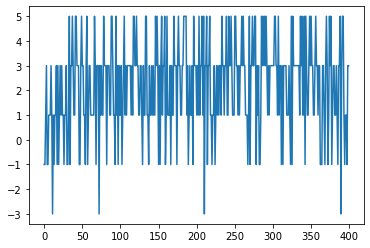

In [14]:
plt.plot(SCORES) # The higher the value, the more success

Now it's time to evaluate the learning method on the full data set:

In [15]:
actions = [i for i in range(FULL_SIZE)] # Now we're working with the full set of clusters
actions.remove(START_NODE)
state = (START_NODE, [START_NODE], actions, 0)

traveled_distance = 0
actions = [START_NODE] # We will now re-utilize actions as a memory of the actions taken in order
while state!=None:
    action = select_action(state, opt=True)
    actions.append(action)
        
    D = total_distance(state[0], action)
    traveled_distance += D
    print(D) # This print statement allows us to monitor the movements and see notice any unnecessarily long paths
    state = (action, state[1]+[action], state[2], state[3]+D)
    if len(state[2])==0:
        state = None
        
actions

11.722989652187369
30.764891452547644
54.252154904730396
48.5067607168949
36.00073002457447
42.40408406428894
12.11613576148333
4.7520946096437
8.92754224346759
5.821861453032888
5.218602507375569
34.327504581611706
19.00496891119527
32.410646250042376
11.003478535030148
11.971126551189393
6.445956457673559
5.376127163513863
1.432658515533858
8.046680044800437
5.597827711296021


[0, 14, 8, 13, 12, 20, 18, 15, 4, 19, 1, 5, 21, 7, 11, 3, 2, 17, 10, 9, 16, 6]

Listed below is the travel distance during evaluation. Note that a random path may average around 600 miles, and go as high as 1000 miles.

In [16]:
traveled_distance

396.1048221121133

Finally, let's store this pathing process as a gif.

In [17]:
# Here we compile the roads taken by action # and x, y coordinates
directions_x = [[] for _ in range(len(actions)-1)]
directions_y = [[] for _ in range(len(actions)-1)]

for i in range(1, len(actions)):
    p1, p2 = clusters[actions[i-1]][0], clusters[actions[i]][0]
    temp = nx.shortest_path(Atascosa, p1, p2, weight='Distance')
    for x in temp:
        directions_x[i-1].append(x[0])
        directions_y[i-1].append(x[1])

MovieWriter ffmpeg unavailable; using Pillow instead.


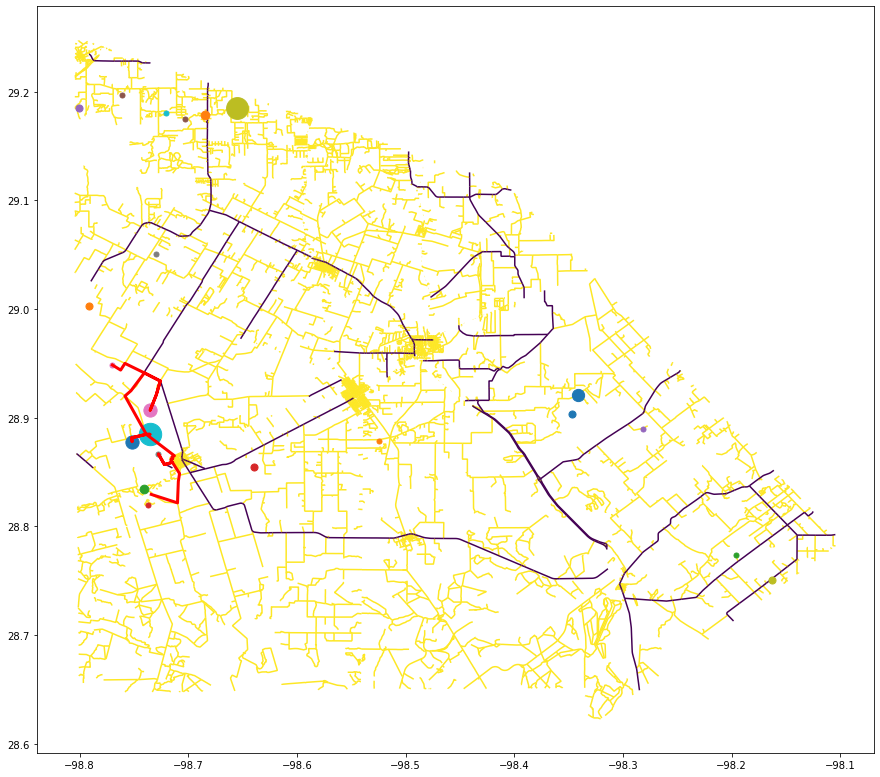

In [18]:
import matplotlib.animation as animation

basemap = gpd.read_file(r'Maps\Basemap013\road013l.shp')

fig, ax = plt.subplots(figsize=(15,15))
xs = []
ys = []
line, = ax.plot(xs, ys, color='r', linewidth=3)

basemap.plot(column='DISP_CODE', ax=ax, figsize=(15,15), zorder=0)

for C in clusters:
    plt.scatter(C[0][0], C[0][1], s=25*C[1])

FULL_DIRECTIONS_X, FULL_DIRECTIONS_Y = [x for X in directions_x for x in X ], [y for Y in directions_y for y in Y ]

# This function is called periodically from FuncAnimation
def animate(i, xs=xs, ys=ys):
    # Add x and y to lists
    xs.append(FULL_DIRECTIONS_X[i])
    ys.append(FULL_DIRECTIONS_Y[i])

    # Limit x and y lists
    line_length = 50
    xs = xs[-line_length:]
    ys = ys[-line_length:]

    line.set_data(np.array(xs), np.array(ys))
    
    return line,

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, frames=len(FULL_DIRECTIONS_X))
ani.save(r'Atascosa_batch_pathing_animation.gif', fps=2500)
plt.show()

### Storing the Learner:

The following code below will store the Learning Algorithm as a pth file:

In [19]:
print(policy_net)
torch.save(policy_net, 'Models\Atascosa_Batch.pth')

DQN(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In order to load the Learner, run the following cells:

In [20]:
# Model class must be defined somewhere - commented out as class is already included in notebook
'''class DQN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(DQN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.LeakyReLU(0.2)
            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.iter = 0
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output'''

'class DQN(nn.Module):\n        def __init__(self, input_size, hidden_size):\n            super(DQN, self).__init__()\n            self.input_size = input_size\n            self.hidden_size  = hidden_size\n            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)\n            self.relu = torch.nn.LeakyReLU(0.2)\n            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)\n            self.sigmoid = torch.nn.Sigmoid()\n            \n            self.iter = 0\n            \n        def forward(self, x):\n            hidden = self.fc1(x)\n            relu = self.relu(hidden)\n            output = self.fc2(relu)\n            output = self.sigmoid(output)\n            return output'

In [21]:
model = torch.load('Models\Atascosa_Batch.pth')
model.eval()

DQN(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)